In [1]:
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import time

import scipy.misc

import os
import pickle
import sys

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve

# Helper

### Training
Modified based on the training loop of: https://colab.research.google.com/github/csc413-uoft/2021/blob/master/assets/assignments/a2-cnn.ipynb

In [2]:
def evaluate(model, loader, criterion, gpu):
  model.eval()
  correct = 0.
  total = 0.
  val_loss = 0.
  for i, (inputs, labels) in enumerate(loader, 0):
    with torch.no_grad():
      if gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()
      pred = model(inputs)
      xentropy_loss = criterion(pred, labels)
      val_loss += xentropy_loss.item()

    pred = torch.max(pred.data, 1)[1]
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  val_acc = correct / total
  val_loss = val_loss / i 
  model.train()

  return val_acc * 100, val_loss

In [3]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn):
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()

    # DATA
    print("Loading data...")
    trainloader = torch.utils.data.DataLoader(
        args.train_set, batch_size=args.batch_size, 
        shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(
        args.valid_set, batch_size=args.batch_size, 
        shuffle=False, num_workers=2)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    device = "cpu"
    if args.gpu:
        if torch.cuda.is_available():
            print("Using cuda")
            device = torch.device("cuda")

    print("Beginning training ...")
    cnn.to(device)
    train_start = time.time()
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        optimizer = optim.SGD(
            model.parameters(), lr=args.initial_lr * (args.lr_decay ** epoch), 
            momentum=0.9, weight_decay=args.weight_decay, nesterov=True)
        epoch_start = time.time()
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        losses = []
        for i, (images, labels) in enumerate(trainloader, 0):
            images = images.to(device)
            labels = labels.to(device)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # Print training info
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        epoch_time = time.time() - epoch_start
        print(
            "Epoch [%d/%d], Loss: %.4f, Epoch Time (s): %.2f"
            % (epoch + 1, args.epochs, avg_loss, epoch_time)
        )

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_start = time.time()
        val_acc, val_loss = evaluate(cnn, validloader, criterion, args["gpu"])

        time_elapsed = time.time() - val_start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.3f%%, Validation Time: %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # Print Total Training Time
    print(
        "Total Training Time: %.2f"
        % (time.time() - train_start)
    )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "r,-", label="Train")
    plt.plot(valid_losses, "g,-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    # Plot validation accuracy
    plt.figure()
    plt.plot(valid_accs, "g,-", label="Validation")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/accuracy_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

### Data Loader

In [4]:
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/17a7c7cb80916fcdf921097825a0f562/cifar10_tutorial.ipynb#scrollTo=WR_b-BQ7nupu
# Transform for MNIST
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.1307,),(0.3081,))])

# Transform for CIFAR
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
# trainset = torchvision.datasets.MNIST(root='./data', train=True,
#                                         download=True, transform=transform)
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

validset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
# validset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        download=True, transform=transform)
# validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      #  download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=256,
                                         shuffle=False, num_workers=2)


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Custom Convolution Layers

In [5]:
# Depth Wise Separable Convolution
# https://discuss.pytorch.org/t/how-to-modify-a-conv2d-to-depthwise-separable-convolution/15843/6
class conv_dw(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size=3, bias=True):
    super(conv_dw, self).__init__()
    self.depthwise = nn.Conv2d(
        in_channels, 
        in_channels, 
        stride=stride,
        kernel_size=kernel_size, 
        padding=1, 
        groups=in_channels,
        bias=bias
        )
    self.pointwise = nn.Conv2d(
        in_channels, 
        out_channels, 
        kernel_size=1,
        bias=bias
        )
    self.ReLU = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    out = self.depthwise(x)
    out = self.bn1(out)
    out = self.ReLU(out)
    out = self.pointwise(out)
    out = self.bn2(out)
    out = self.ReLU(out)
    return out

In [6]:
# Convolution followed by batch nomrlaization and ReLU
class conv_bn(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size=3, bias=True):
    super(conv_bn, self).__init__()
    self.conv = nn.Conv2d(
        in_channels, out_channels, kernel_size, stride, padding=1, bias=bias)
    self.ReLU = nn.ReLU()
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.ReLU(out)
    return out

In [7]:
# Transposed Convolution followed by batch nomrlaization and ReLU
class conv_transpose_bn(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size=3, bias=True):
    super(conv_transpose_bn, self).__init__()
    self.conv = nn.ConvTranspose2d(
        in_channels, out_channels, stride=2, kernel_size=kernel_size, 
        padding=1, output_padding=1, bias=bias)
    self.ReLU = nn.ReLU()
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.ReLU(out)
    return out

# Depthwise Convolution Network

In [8]:
class DepthwiseConvNet(nn.Module):
    def __init__(self, in_channel, out_classes):
        super(DepthwiseConvNet, self).__init__()
        
        self.conv_model = nn.Sequential(
            conv_transpose_bn(in_channel, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifer = nn.Sequential(
            nn.Linear(1024, out_classes),
        )
      

    def forward(self, x):
        out = self.conv_model(x)
        out = torch.reshape(out, (-1, 1024))
        out = self.classifer(out)
        return out


In [9]:
if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    device = "cpu"

criterion = nn.CrossEntropyLoss()
criterion.to(device)
model = DepthwiseConvNet(3, 100)

model.to(device)
model.train()

# optimizer = optim.SGD(model.parameters(), lr=0.0125, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, 
#                       weight_decay=0.0005, nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Using cuda


DepthwiseConvNet(
  (conv_model): Sequential(
    (0): conv_transpose_bn(
      (conv): ConvTranspose2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (ReLU): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): conv_dw(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (ReLU): ReLU()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): conv_dw(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (ReLU): ReLU()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Loading data...
Using cuda
Beginning training ...
Epoch [1/270], Loss: 4.3254, Epoch Time (s): 17.94
Epoch [1/270], Val Loss: 4.6805, Val Acc: 2.940%, Validation Time: 2.00
Epoch [2/270], Loss: 3.7792, Epoch Time (s): 17.68
Epoch [2/270], Val Loss: 4.3036, Val Acc: 5.720%, Validation Time: 1.97
Epoch [3/270], Loss: 3.3271, Epoch Time (s): 17.79
Epoch [3/270], Val Loss: 3.7119, Val Acc: 14.190%, Validation Time: 1.99
Epoch [4/270], Loss: 2.9176, Epoch Time (s): 17.71
Epoch [4/270], Val Loss: 3.3429, Val Acc: 20.990%, Validation Time: 1.97
Epoch [5/270], Loss: 2.5804, Epoch Time (s): 17.78
Epoch [5/270], Val Loss: 3.1204, Val Acc: 24.780%, Validation Time: 1.96
Epoch [6/270], Loss: 2.2972, Epoch Time (s): 17.78
Epoch [6/270], Val Loss: 2.7595, Val Acc: 33.720%, Validation Time: 1.97
Epoch [7/270], Loss: 2.0860, Epoch Time (s): 17.74
Epoch [7/270], Val Loss: 2.7511, Val Acc: 33.040%, Validation Time: 1.99
Epoch [8/270], Loss: 1.9177, Epoch Time (s): 17.81
Epoch [8/270], Val Loss: 2.3397, 

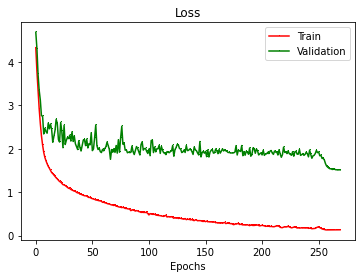

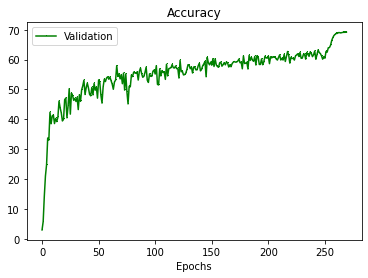

In [10]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "initial_lr":0.0125, 
    "lr_decay":0.99, 
    "batch_size": 256,
    "weight_decay": 0.01,
    "epochs": 270,
    "train_set": trainset,
    "valid_set": validset,
    "experiment_name": "depthwise_convnet",
    "checkpoint": ""
}
args.update(args_dict)
dw_cnn = train(args, model)

In [11]:
correct = 0
total = 0
start = time.time()
validloader = torch.utils.data.DataLoader(
    args.valid_set, batch_size=args.batch_size, 
    shuffle=False, num_workers=2)
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = dw_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %.3f%%' % (
    100 * correct / total))
print(
    "Time: %.2f"
    % (time.time() - start)
)

Accuracy of the network on the test images: 68.990%
Time: 2.01


In [12]:
correct = 0
total = 0
start = time.time()
trainloader = torch.utils.data.DataLoader(
    args.train_set, batch_size=args.batch_size, 
    shuffle=False, num_workers=2)
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = dw_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %.3f%%' % (
    100 * correct / total))
print(
    "Time: %.2f"
    % (time.time() - start)
)

Accuracy of the network on the train images: 99.944%
Time: 9.15


# Ordinary Convolution Network

In [13]:
class ConvNet(nn.Module):
    def __init__(self, in_channel, out_classes):
        super(ConvNet, self).__init__()
        self.conv_model = nn.Sequential(
            conv_transpose_bn(in_channel, 32, 2),
            conv_bn(32, 64, 1),
            conv_bn(64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifer = nn.Sequential(
            nn.Linear(1024, out_classes),
        )
      

    def forward(self, x):
        out = self.conv_model(x)
        out = torch.reshape(out, (-1, 1024))
        out = self.classifer(out)
        return out


In [14]:
if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    device = "cpu"

criterion = nn.CrossEntropyLoss()
criterion.to(device)
model = ConvNet(3, 100)

model.to(device)
model.train()

Using cuda


ConvNet(
  (conv_model): Sequential(
    (0): conv_transpose_bn(
      (conv): ConvTranspose2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (ReLU): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): conv_bn(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): conv_bn(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (ReLU): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): conv_bn(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ReLU): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): conv_bn(
      (conv): Conv2d(128, 256, 

Loading data...
Using cuda
Beginning training ...
Epoch [1/50], Loss: 3.7423, Epoch Time (s): 33.26
Epoch [1/50], Val Loss: 3.9042, Val Acc: 10.690%, Validation Time: 2.21
Epoch [2/50], Loss: 3.0981, Epoch Time (s): 33.23
Epoch [2/50], Val Loss: 3.4616, Val Acc: 19.110%, Validation Time: 2.22
Epoch [3/50], Loss: 2.7148, Epoch Time (s): 33.21
Epoch [3/50], Val Loss: 3.0520, Val Acc: 30.420%, Validation Time: 2.21
Epoch [4/50], Loss: 2.4949, Epoch Time (s): 33.22
Epoch [4/50], Val Loss: 3.2168, Val Acc: 27.780%, Validation Time: 2.21
Epoch [5/50], Loss: 2.3293, Epoch Time (s): 33.25
Epoch [5/50], Val Loss: 3.2521, Val Acc: 27.100%, Validation Time: 2.25
Epoch [6/50], Loss: 2.2005, Epoch Time (s): 33.23
Epoch [6/50], Val Loss: 2.7083, Val Acc: 37.110%, Validation Time: 2.20
Epoch [7/50], Loss: 2.0906, Epoch Time (s): 33.20
Epoch [7/50], Val Loss: 2.7596, Val Acc: 33.260%, Validation Time: 2.22
Epoch [8/50], Loss: 1.9838, Epoch Time (s): 33.12
Epoch [8/50], Val Loss: 3.4930, Val Acc: 25.40

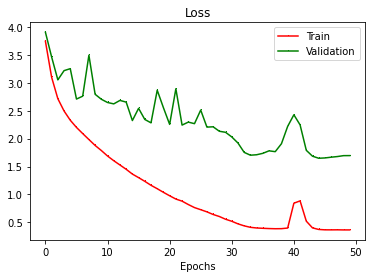

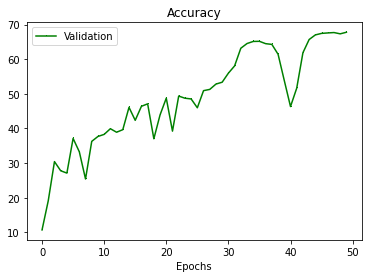

In [15]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "initial_lr":0.0125, 
    "lr_decay": 0.95, 
    "batch_size": 256,
    "weight_decay": 0.0225,
    "epochs": 50,
    "train_set": trainset,
    "valid_set": validset,
    "experiment_name": "ordinary_convnet",
    "checkpoint": ""
}
args.update(args_dict)
cnn = train(args, model)

In [16]:
correct = 0
total = 0
start = time.time()
validloader = torch.utils.data.DataLoader(
    args.valid_set, batch_size=args.batch_size, 
    shuffle=False, num_workers=2)
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %.3f%%' % (
    100 * correct / total))
print(
    "Time: %.2f"
    % (time.time() - start)
)

Accuracy of the network on the test images: 67.230%
Time: 2.27


In [17]:
correct = 0
total = 0
start = time.time()
trainloader = torch.utils.data.DataLoader(
    args.train_set, batch_size=args.batch_size, 
    shuffle=False, num_workers=2)
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %.3f%%' % (
    100 * correct / total))
print(
    "Time: %.2f"
    % (time.time() - start)
)

Accuracy of the network on the train images: 98.284%
Time: 10.21


# Saving Models

In [19]:
torch.save(cnn.state_dict(), "cnn")
torch.save(dw_cnn.state_dict(), "dw_cnn")